# Vanilla GAN for Moving Box Prediction

In [1]:
from util import *
from util.parser import *
from util.img_kit import *
from util.notebook_display import *
from util.numeric_ops import *
from IPython import display
import numpy as np
from scipy import ndimage
from scipy import misc
from os import walk
import os
import tensorflow as tf
from PIL import Image

import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['figure.figsize'] = (5.0, 5.0) # set default size of plots
plt.rcParams['image.cmap'] = 'gray'

%load_ext autoreload
%autoreload 2

In [2]:
def get_session():
    config = tf.ConfigProto()
    config.gpu_options.allow_growth = True
    session = tf.Session(config=config)
    return session

## Load data

imgs shape:     (14, 32, 32)
info:           {'images:': 'moving box uniform', 'dim': (14, 32, 32)}


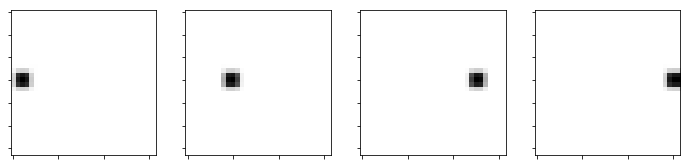

In [3]:
data_path = "data/moving-box/processed/single-uniform-32x32.npz"
data = np.load(data_path)
imgs, info = data['imgs'], data['info']
print("imgs shape:     {}".format(imgs.shape))
print("info:           {}".format(info))
num_train = imgs.shape[0]
sample_and_show_many(imgs, 4)

### Proprocess: [0, 1] -> [-1, 1]

In [4]:
def preprocess(imgs):
    return imgs*2 - 1

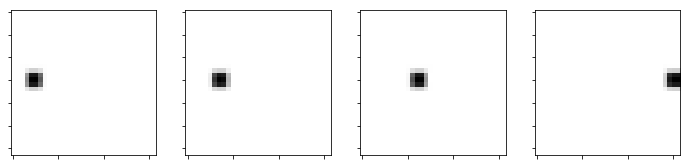

In [5]:
imgs = preprocess(imgs)
sample_and_show_many(imgs, 4)

#### Sample Data from Training Corpus

In [6]:
gap = 3
batch_size = 8
def sample_real():
    """
    return: (before, after), mid
    """
    before_indexes = np.random.choice(range(len(imgs) - gap - 1), batch_size, replace=False)
    before_indexes.sort()
    after_indexes = before_indexes + gap + 1
    mid_indexes = (before_indexes + after_indexes)//2
    return (imgs[before_indexes], imgs[after_indexes]), imgs[mid_indexes]

#### test sample_real

Before: (8, 32, 32)
After:  (8, 32, 32)
Mid:    (8, 32, 32)


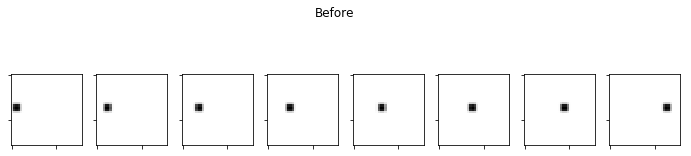

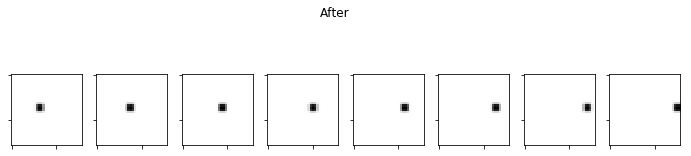

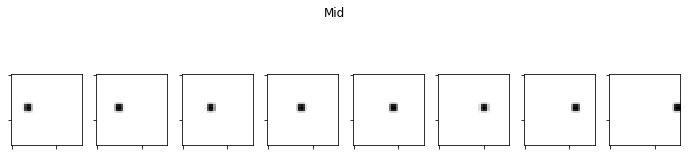

In [7]:
(test_before, test_after), test_mid = sample_real()
print("Before: {}".format(test_before.shape))
print("After:  {}".format(test_after.shape))
print("Mid:    {}".format(test_mid.shape))
size = (12, 3)
plot_images(test_before, size, "Before")
plot_images(test_after, size, "After")
plot_images(test_mid, size, "Mid")

#### test stack

In [8]:
stacked = stack_imgs([test_before, test_after])
print("Stacked: {}".format(stacked.shape))

Stacked: (8, 32, 32, 2)


## GAN

In [9]:
def leaky_relu(x, alpha=0.01):
    return tf.maximum(alpha * x, x)

### Params

In [10]:
learning_rate = 1e-4
beta = 0.5
num_epoch = 600
noise_dim = 128

### Loss

In [11]:
def gan_loss(logits_real, logits_fake):
    G_loss = tf.nn.sigmoid_cross_entropy_with_logits(labels=tf.ones_like(logits_fake), logits = logits_fake)
    
    D_loss = tf.nn.sigmoid_cross_entropy_with_logits(labels=tf.ones_like(logits_real), logits = logits_real)\
     +  tf.nn.sigmoid_cross_entropy_with_logits(labels=tf.zeros_like(logits_fake), logits = logits_fake)
        
    G_loss = tf.reduce_mean(G_loss)
    D_loss = tf.reduce_mean(D_loss)
    return D_loss, G_loss

## Discriminator

In [12]:
def discriminate(x):
    with tf.variable_scope("discriminator"):
        x = tf.reshape(x, [-1,  32, 32, 1])
        x = tf.layers.conv2d(x, filters=32, kernel_size=5)
        x = leaky_relu(x, 0.01)
        x = tf.nn.max_pool(x, ksize=[1, 2, 2, 1], strides=[1,2,2,1], padding="VALID")
        
        x = tf.layers.conv2d(x, 64, kernel_size=5)
        x = leaky_relu(x, 0.01)
        x = tf.nn.max_pool(x, ksize=[1, 2, 2, 1], strides=[1,2,2,1], padding="VALID")
        
        x = tf.contrib.layers.flatten(x)
        x = tf.layers.dense(x, 4*4*64)
        x = leaky_relu(x, 0.01)
        logits = tf.layers.dense(x, 1)
        return logits

## Generator

In [13]:
def generate(x1, x2,  is_training=True):
    """
    Input:
        x1, x2: batch size of images for inference
    Output:
        predicted images of batch size
    """
    with tf.variable_scope("generator"):
        # reshape and concatenate
        x1 = tf.reshape(x1, [-1,  32, 32, 1])
        x2 = tf.reshape(x2, [-1,  32, 32, 1])
        x = tf.concat([x1, x2], axis=3)
        
        x = tf.contrib.layers.flatten(x)
        x = tf.layers.dense(x, 1024, activation=tf.nn.relu)
        x = tf.layers.batch_normalization(x, training=is_training)
        
        x = tf.layers.dense(x, 8*8*128, activation=tf.nn.relu)
        x = tf.layers.batch_normalization(x, training=is_training)
        x = tf.reshape(x, [-1, 8, 8, 128])
        
        x = tf.layers.conv2d_transpose(x, filters=64, kernel_size=(4, 4), strides=(2, 2), activation=tf.nn.relu, padding='same')
        x = tf.layers.batch_normalization(x, training=is_training)
        
        img = tf.layers.conv2d_transpose(x, filters=1, kernel_size=(4, 4),  strides=(2, 2), activation=tf.nn.tanh, padding='same')
        img = tf.reshape(img, [-1, 32, 32, 1])
        return img

### Solver

In [14]:
def get_solvers(learning_rate=1e-3, beta1=0.5):
    D_solver = tf.train.AdamOptimizer(learning_rate=learning_rate, beta1=beta1)
    G_solver = tf.train.AdamOptimizer(learning_rate=learning_rate, beta1=beta1)
    return D_solver, G_solver

### Run a GAN !

In [15]:
tf.reset_default_graph()
batch_mid        = tf.placeholder(tf.float32, [None, 32, 32])
batch_before     = tf.placeholder(tf.float32, [None, 32, 32])
batch_after      = tf.placeholder(tf.float32, [None, 32, 32])
is_training      = tf.placeholder(tf.bool, ())

G_batch = generate(batch_before, batch_after)

with tf.variable_scope("") as scope:
    logits_real = discriminate(batch_mid)
    scope.reuse_variables()
    logits_fake = discriminate(G_batch)

D_loss, G_loss = gan_loss(logits_real, logits_fake)
D_solver, G_solver = get_solvers(learning_rate, beta)

D_vars = tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES, 'discriminator')
G_vars = tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES, 'generator') 

D_train_step = D_solver.minimize(D_loss, var_list=D_vars)
G_train_step = G_solver.minimize(G_loss, var_list=G_vars)

In [16]:
def train(sess, G_step, D_step, G_loss, D_loss, batch_size, num_eposh, plot_every = 40, show_loss_every=40):
    max_iter = int(num_train*num_epoch/batch_size)
    d_losses, g_losses = [], []
    for i in range(max_iter):
        (real_before, real_after), real_mid = sample_real()
        
        dic = {batch_mid: real_mid, batch_before: real_before, batch_after: real_after, is_training: True}
        _, D_loss_curr = sess.run([D_train_step, D_loss], dic)
        _, G_loss_curr = sess.run([G_train_step, G_loss], dic)
        
        if i%show_loss_every ==0:
            print("Iteration {}: D_loss = {} | G_loss = {}".format(i, D_loss_curr, G_loss_curr))
            d_losses.append(D_loss_curr)
            g_losses.append(G_loss_curr)
        if i%plot_every == 0:
            gen_batch_test = sess.run(G_batch, feed_dict={batch_before: test_before, batch_after: test_after, is_training: False})
            plot_batch_images(gen_batch_test, (16, 2) , "Iteration: {}".format(i))
    
    figsize = (16, 3)
    plt.figure(figsize=figsize)
    plt.plot(d_losses)
    plt.title("Discriminator Losses")
    plt.show()
    
    plt.figure(figsize=figsize)
    plt.plot(g_losses)
    plt.title("Generator Losses")
    plt.show()

Iteration 0: D_loss = 1.4158005714416504 | G_loss = 0.8479797840118408


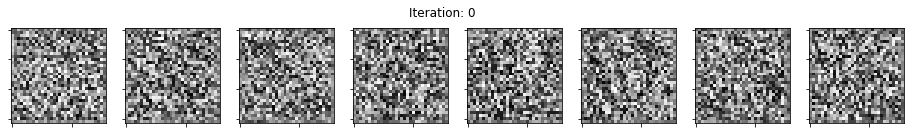

Iteration 40: D_loss = 0.3690353333950043 | G_loss = 3.2219462394714355


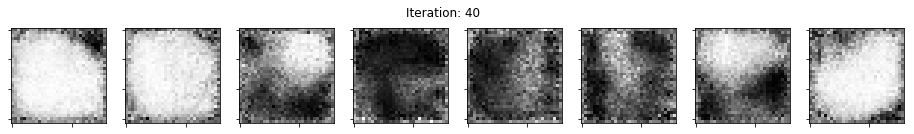

Iteration 80: D_loss = 0.4418748617172241 | G_loss = 2.7029833793640137


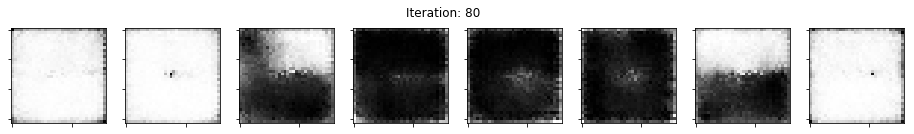

Iteration 120: D_loss = 0.7168034911155701 | G_loss = 4.235191822052002


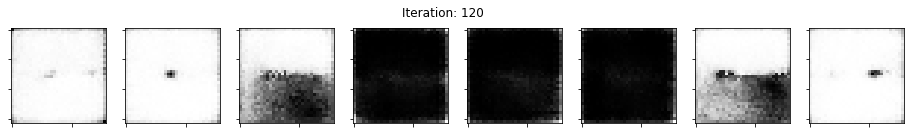

Iteration 160: D_loss = 0.5215568542480469 | G_loss = 3.7752394676208496


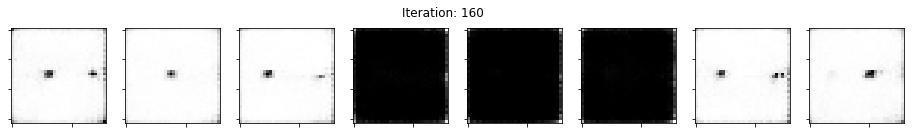

Iteration 200: D_loss = 0.9056932926177979 | G_loss = 4.7030930519104


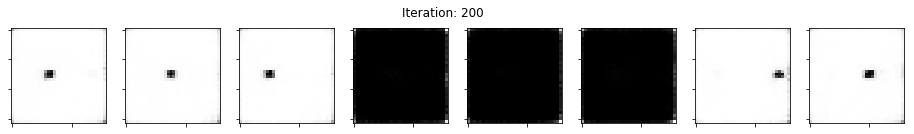

Iteration 240: D_loss = 0.8866786360740662 | G_loss = 4.976090908050537


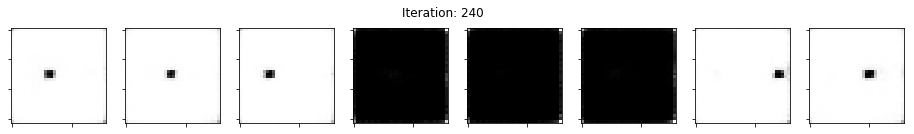

Iteration 280: D_loss = 0.9162269830703735 | G_loss = 5.254861831665039


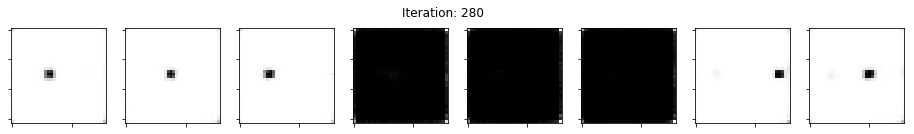

Iteration 320: D_loss = 1.223318338394165 | G_loss = 3.766263961791992


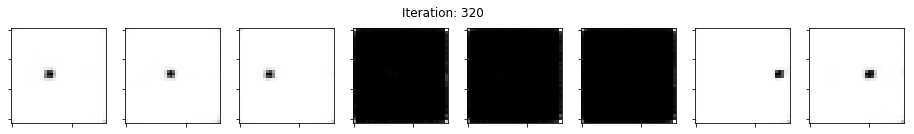

Iteration 360: D_loss = 0.8534866571426392 | G_loss = 5.987461090087891


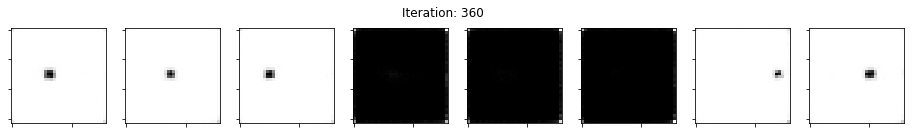

Iteration 400: D_loss = 0.938042402267456 | G_loss = 4.34348201751709


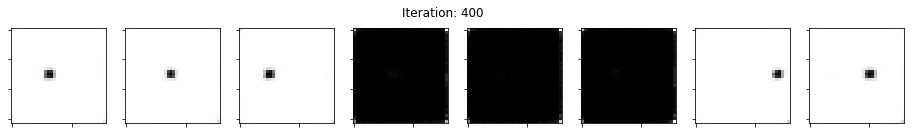

Iteration 440: D_loss = 0.9673055410385132 | G_loss = 5.882340431213379


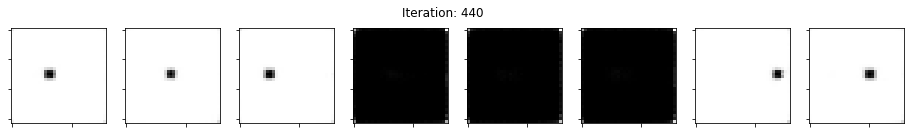

Iteration 480: D_loss = 0.9517192840576172 | G_loss = 4.291305065155029


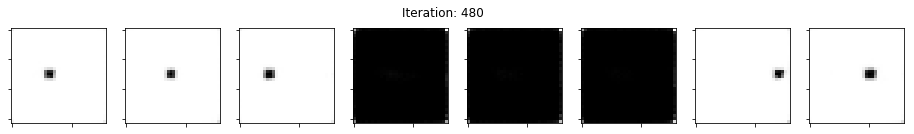

Iteration 520: D_loss = 1.0949677228927612 | G_loss = 5.972517013549805


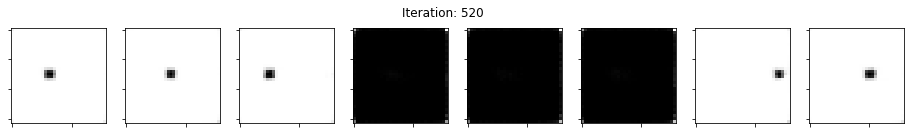

Iteration 560: D_loss = 1.034798264503479 | G_loss = 5.894735813140869


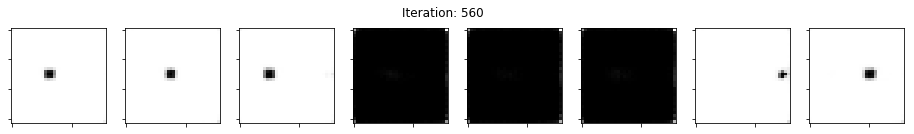

Iteration 600: D_loss = 0.796291708946228 | G_loss = 2.7606873512268066


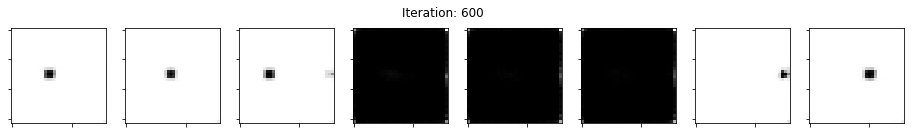

Iteration 640: D_loss = 0.9542010426521301 | G_loss = 3.429083824157715


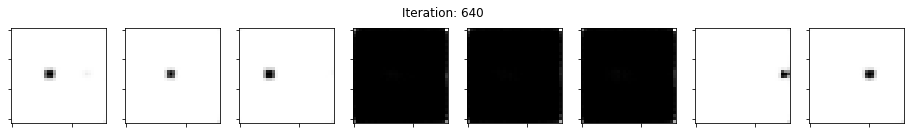

Iteration 680: D_loss = 0.920954167842865 | G_loss = 6.876940727233887


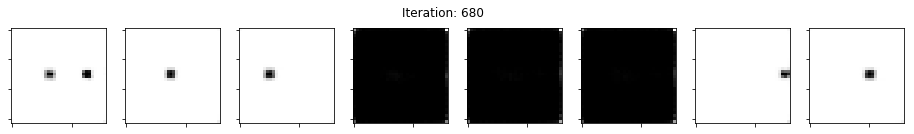

Iteration 720: D_loss = 1.0631802082061768 | G_loss = 4.981544494628906


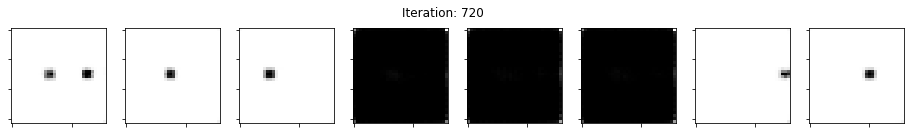

Iteration 760: D_loss = 1.0615134239196777 | G_loss = 4.751551628112793


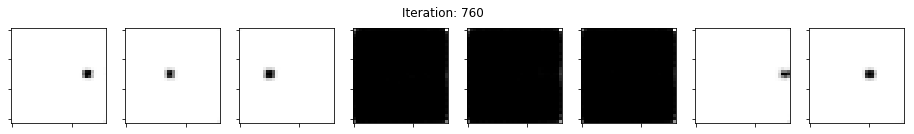

Iteration 800: D_loss = 1.1002435684204102 | G_loss = 4.821393013000488


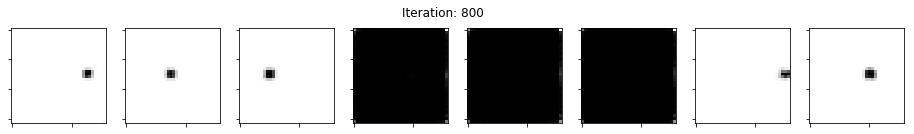

Iteration 840: D_loss = 1.0434041023254395 | G_loss = 4.657248497009277


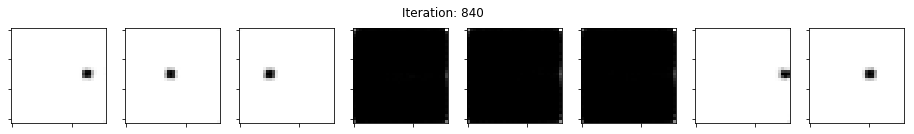

Iteration 880: D_loss = 0.8537651300430298 | G_loss = 6.8425750732421875


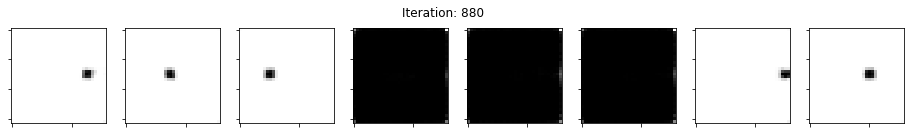

Iteration 920: D_loss = 0.9004650115966797 | G_loss = 6.855828285217285


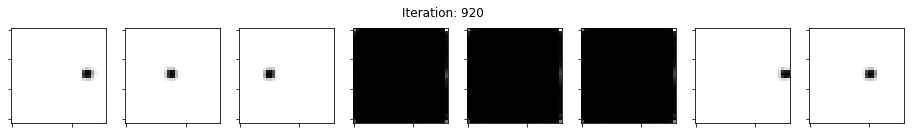

Iteration 960: D_loss = 1.0650269985198975 | G_loss = 5.001996040344238


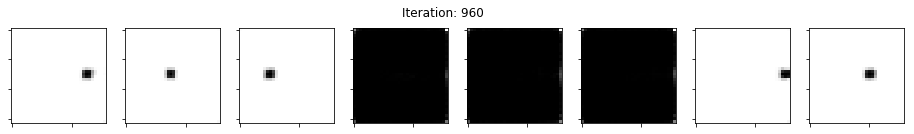

Iteration 1000: D_loss = 1.0917168855667114 | G_loss = 4.874693870544434


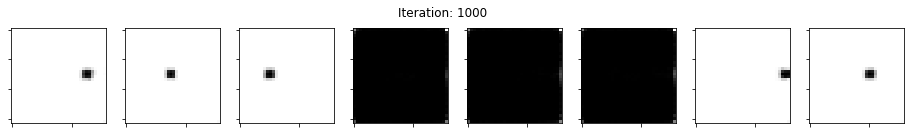

Iteration 1040: D_loss = 1.0457220077514648 | G_loss = 5.032311916351318


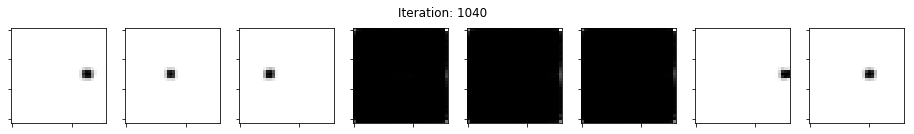

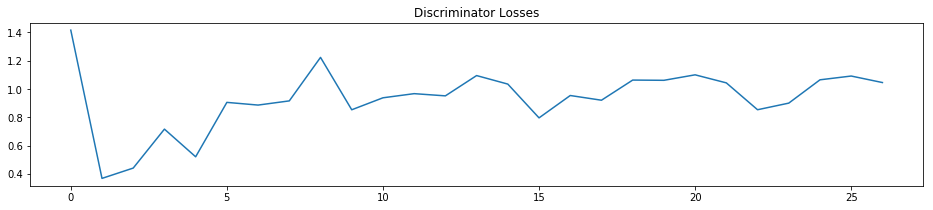

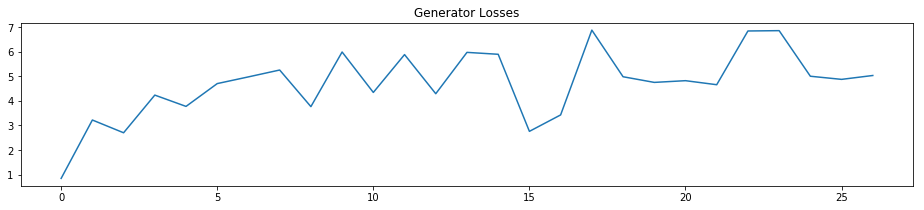

In [17]:
sess = get_session()
sess.run(tf.global_variables_initializer())
train(sess, G_train_step, D_train_step, G_loss, D_loss, batch_size, num_epoch)

#### test

In [18]:
def test():
    """
    randomely sample and test generator
    """
    (real_before, real_after), real_mid = sample_real()
    dic = {batch_before: real_before, batch_after: real_after, is_training: False}
    gen_batch = sess.run(G_batch, dic)
    size = (12, 2)
    plot_images(real_before, size, "Before")
    plot_images(real_after, size, "After")
    plot_images(real_mid, size, "Mid - Real")
    plot_images(gen_batch, size, "Mid - Generated")

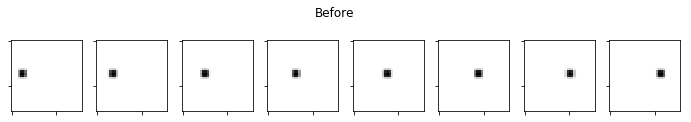

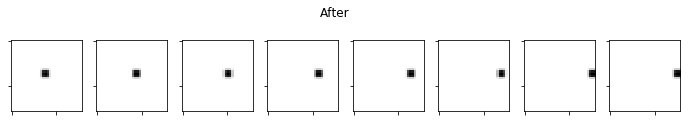

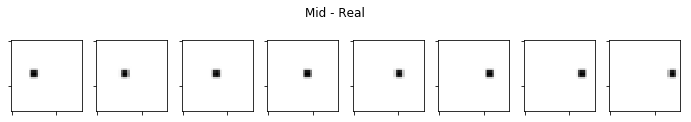

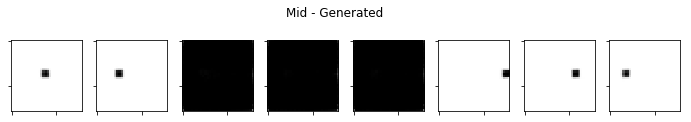

In [21]:
test()